# Import libraries

In [26]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset,random_split
import torch.nn as nn
from torchvision.utils import make_grid
import os
import torch.optim as optim
from tqdm import tqdm
# os.chdir("../../kaggle/")
import random
from  matplotlib import pyplot as plt

from torch.optim.lr_scheduler import LambdaLR

In [27]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [28]:
!pip install deepspeed

In [29]:
import deepspeed as ds


# Data Preprocessing

In [56]:
# Data Augmentation
transformation = transforms.Compose(
    [
        transforms.Resize([286,286],antialias=True),
        transforms.RandomCrop((256, 256)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2,
              saturation=0.2, hue=0.1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225]),
        
    ])



In [31]:
# Storing the image using custom dataset
class SummerWinter(Dataset):
    def __init__(self,root_summer,root_winter,transform = None):
        super().__init__()
        self.root_summer = root_summer
        self.root_winter = root_winter
        self.transform = transform
        self.summer_images = (os.listdir(self.root_summer))
        self.winter_images = (os.listdir(self.root_winter))
        
    def __len__(self):
        return max(len(self.summer_images),len(self.winter_images))
    def __getitem__(self,index):
        summer_image = self.summer_images[index % len(self.summer_images)]
        winter_image = self.winter_images[index % len(self.winter_images)]
        
        summer_path = os.path.join(self.root_summer,summer_image)
        winter_path = os.path.join(self.root_winter,winter_image)
        
        summer_img = Image.open(summer_path).convert("RGB")
        winter_img = Image.open(winter_path).convert("RGB")
        
        if self.transform:
            summer_img_trans = self.transform(summer_img)
            winter_img_trans = self.transform(winter_img)
            
        return summer_img_trans,winter_img_trans

# Build Discriminator

In [32]:
class Disc_Block(nn.Module):
    def __init__(self,in_channels,out_channels,normalize = True,stride=1):
        super().__init__()
        layers = [nn.Conv2d(in_channels,out_channels,4,stride,1 ,padding_mode='reflect')]
        if normalize:
            layers.append( nn.InstanceNorm2d(out_channels, affine=True))
        layers.append(nn.LeakyReLU(0.2,inplace=True))
        self.conv = nn.Sequential(
            *layers
        )
        
    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    def __init__(self,in_channels = 3):
        super().__init__()
        self.model = nn.Sequential(
            Disc_Block(in_channels,64,normalize=False,stride=2),
            Disc_Block(64,128),
            Disc_Block(128,256),
            Disc_Block(256,512),
            nn.Conv2d(512,1,kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",)
        )
    def forward(self,x):
        return torch.sigmoid(self.model(x))
    
# Check size of image after disc
x = torch.randn((5, 3, 256, 256))
model = Discriminator()
preds = model(x)
print(preds.mean().item())
        

0.5383779406547546


# Build the Generator

In [33]:
class Gen_Block(nn.Module):
    def __init__(self,in_channels,out_channels,down = True,use_act=True,normalize = True, **kwargs):
        super().__init__()
        layers = [ nn.Conv2d(in_channels,out_channels ,**kwargs)
                  if down 
                  else 
                   nn.ConvTranspose2d(in_channels, out_channels, **kwargs)
                 ]
        if normalize:
            layers.append( nn.InstanceNorm2d(out_channels, affine=True))
        layers.append(nn.ReLU(inplace=True) if use_act else nn.Identity())
        self.conv = nn.Sequential(
            *layers
        )
    def forward(self, x):
        return self.conv(x)
    
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            Gen_Block(channels, channels, kernel_size=3, padding=1),
            Gen_Block(channels, channels,use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)
    
class Generator(nn.Module):
    def __init__(self,img_channels=3,num_features = 64,num_residuals = 9 ):
        super().__init__()
        self.down_blocks = nn.Sequential(
            Gen_Block(img_channels,num_features,normalize=False, kernel_size=7,
                      stride=1, padding=3, padding_mode='reflect'),
            Gen_Block(num_features,num_features*2, kernel_size=3, stride=2, padding=1),
            Gen_Block(num_features*2,num_features*4,kernel_size=3, stride=2, padding=1),
        )
        
        self.residual_blocks = nn.Sequential(
        *[ResidualBlock(num_features*4)
          for _ in range(0,num_residuals)]
        )
        
        self.up_blocks = nn.Sequential(
            Gen_Block(num_features*4,num_features*2,down=False, 
                      kernel_size=3, stride=2, padding=1, output_padding=1),
            Gen_Block(num_features*2,num_features*1,down=False, 
                      kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(num_features*1, img_channels, kernel_size=7,
                              stride=1, padding=3, padding_mode='reflect')
        )
    def forward(self,x):
        x = self.down_blocks(x)
#         print("After down block size image = ",x.shape)
        x = self.residual_blocks(x)
#         print("After residual block size image = ",x.shape)
        x = self.up_blocks(x)
#         print("After up block size image = ",x.shape)
        return torch.tanh(x)
# Check size of image after generator
x = torch.randn((1, 3, 256, 256))
model = Generator()
preds = model(x)
print(preds.shape)

torch.Size([1, 3, 256, 256])


# Image Buffer

In [34]:
class ImageBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        if len(self.data) < self.max_size:
            self.data.append(data)
            return data
        else:
            if random.uniform(0, 1) > 0.5:
                # Randomly replace an image from the buffer
                idx = random.randint(0, self.max_size - 1)
                replaced_data = self.data[idx]
                self.data[idx] = data
                return replaced_data
            else:
                # Don't use the buffer; return the new data as-is
                return data

# Weight initialization

In [35]:
# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if 'Conv2d' in classname or 'ConvTranspose2d' in classname or 'InstanceNorm2d' in classname:
#         torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
#         if hasattr(m, 'bias') and m.bias is not None:
#             torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
#         elif classname.find('InstanceNorm') != -1:
#             torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
#             torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)


def weights_init_normal(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d,nn.InstanceNorm2d)):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)  # Initialize weights with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)  # Reset bias to constant 0


# Data Preparation

In [36]:
train_dataset = SummerWinter(
    root_summer="/kaggle/input/summer2winter-yosemite" + "/trainA", 
    root_winter="/kaggle/input/summer2winter-yosemite"+ "/trainB", 
    transform=transformation
)
val_dataset = SummerWinter(
    root_summer="/kaggle/input/summer2winter-yosemite" + "/testA", 
    root_winter="/kaggle/input/summer2winter-yosemite"+ "/testB", 
    transform=transformation
)
# # Split dataset into train and validation
# len_dataset = len(dataset)

# train_size = int(0.7 * len_dataset)
# val_size = int(0.3* len_dataset)+1

# train_dataset, val_dataset = random_split(
#     dataset, [train_size, val_size]
# )

In [37]:
# Create data loader
batch_size = 5
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    drop_last= True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=5,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last= True,
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



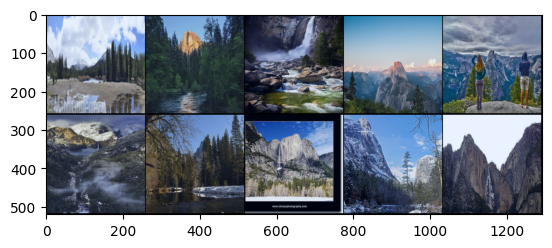

In [38]:
# Let's see some of the images in train loader
photo,monet = next(iter(train_loader ))
photo = make_grid(photo.type(torch.Tensor),nrows=1,normalize=True)
monet = make_grid(monet.type(torch.Tensor),nrows=1,normalize=True)
grid = torch.cat((photo,monet),1)
plt.imshow(grid.permute(1,2,0))
plt.show();

In [39]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


# Training 

In [57]:
# seed_everything()
epochs = 15
lr = 0.0002 # adam : learning rate
device = "cuda"if torch.cuda.is_available else "cpu"
disc_S = Discriminator(in_channels=3).to(device)
disc_W = Discriminator(in_channels=3).to(device)
gen_S = Generator(img_channels=3, num_residuals=9).to(device)
gen_W = Generator(img_channels=3, num_residuals=9).to(device)

gen_S = gen_S.apply(weights_init_normal)
gen_W = gen_W.apply(weights_init_normal)
disc_S = disc_S.apply(weights_init_normal)
disc_W = disc_W.apply(weights_init_normal)


optimizer = ds.ops.adam.FusedAdam if torch.cuda.is_available() else optim.Adam
opt_disc = optimizer(
    list(disc_S.parameters()) + list(disc_W.parameters()),
    lr=lr,
    betas=(0.5, 0.999),
)

opt_gen = optimizer(
    list(gen_S.parameters()) + list(gen_W.parameters()),
    lr=lr,
    betas=(0.5, 0.999),

)
lr_lambda = lambda epoch: 0.1 ** epoch
scheduler_disc = LambdaLR(opt_disc, lr_lambda)
scheduler_gen = LambdaLR(opt_gen, lr_lambda)

#Loss
l1 = nn.L1Loss()
mse = nn.MSELoss()
LOAD_MODEL = False
SAVE_MODEL = True
if LOAD_MODEL:
    load_checkpoint(
      "/kaggle/working/SWgens.pth.tar", gen_S, opt_gen,lr,
    )
    load_checkpoint(
       "/kaggle/working/SWgenw.pth.tar", gen_W, opt_gen, lr,
    )
    load_checkpoint(
        "/kaggle/working/SWdiscs.pth.tar", disc_S, opt_disc, lr,
    )
    load_checkpoint(
        "/kaggle/working/SWdiscw.pth.tar", disc_W, opt_disc, lr,
    )


g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

    

Time to load fused_adam op: 0.001111745834350586 seconds
Time to load fused_adam op: 0.0004794597625732422 seconds


Using /root/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module fused_adam, skipping build step...
Loading extension module fused_adam...
Using /root/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module fused_adam, skipping build step...
Loading extension module fused_adam...


In [58]:
def show_images(loader):
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
    iteration = iter(loader)
    _,_ = (next(iteration))
    summers,winters = (next(iteration))
    gen_S.eval()
    gen_W.eval()
    with torch.no_grad():
        summers = summers.type(Tensor) # A : photo
        fake_winters = gen_W(summers).detach()
        winters = winters.type(Tensor) # B : monet
        fake_summers = gen_S(winters).detach()
        # Arange images along x-axis
        summers = make_grid(summers, nrow=5, normalize=True)
        fake_winters = make_grid(fake_winters, nrow=5, normalize=True)
        winters = make_grid(winters, nrow=5, normalize=True)
        fake_summers = make_grid(fake_summers, nrow=5, normalize=True)
    
    # Arange images along y-axis    
    image_grid = torch.cat((summers, fake_winters, winters, fake_summers), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Summer vs Fake Winter | Winter vs fake Summer')
    plt.axis('off')
    plt.show();

In [59]:
def train_fn(disc_S,disc_W,gen_S,gen_W,opt_disc,opt_gen,l1,mse,d_scaler,g_scaler,train_loader,device,epoch,loss):
    print("Epoch :",epoch)
    print("Load!")

    sum_D_loss = 0
    sum_G_loss = 0
    sum_Adv_loss = 0
    sum_Cycle_loss = 0
    num_samples=0
    sum_Identity_loss=0
    loop = tqdm(train_loader,leave=True)
    for idx,(summers,winters) in enumerate(loop):
        summers = summers.to(device)
        winters = winters.to(device)
        image_buffer_S = ImageBuffer(max_size=100)
        image_buffer_W = ImageBuffer(max_size=100)
        S_reals=0
        S_fakes=0
        gen_S.train()
        gen_W.train()
        with torch.cuda.amp.autocast():
            #Train discriminator of Summer
            #Train it with the real one
            D_S_Real = disc_S(summers)

            #Train it with the fake one
            fake_summers = gen_S(winters)
            #buffer image of summer
            fake_summers = image_buffer_S.push_and_pop(fake_summers)
            D_S_Fake = disc_S(fake_summers.detach()) #To treat the fake images as fixed data
            #Loss of Summer Disc
            D_S_real_loss = mse(D_S_Real,torch.ones_like(D_S_Real))
            D_S_fake_loss = mse(D_S_Fake,torch.zeros_like(D_S_Fake))
            
            #Keep track the discriminator are they doing the job or not
            S_reals += D_S_Real.mean().item()
            S_fakes += D_S_Fake.mean().item()
            D_S_loss = (D_S_real_loss + D_S_fake_loss )
            
            
            #Train discriminator of Winter
            #Train it with the real one
            D_W_Real = disc_W(winters)
            #Train it with the fake one
            fake_winters = gen_S(summers)
            fake_winters = image_buffer_W.push_and_pop(fake_winters)
            D_W_Fake = disc_W(fake_winters.detach()) #To treat the fake images as fixed data
            #Loss of Winter Disc
            D_W_real_loss = mse(D_W_Real,torch.ones_like(D_W_Real))
            D_W_fake_loss = mse(D_W_Fake,torch.zeros_like(D_W_Fake))
            
            D_W_loss = (D_W_real_loss + D_W_fake_loss )
            
            #Put it together
            D_loss = (D_S_loss + D_W_loss) 
            
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        
        # Train generator H AND Z
        with torch.cuda.amp.autocast():
            #Adversarial
            D_S_fake = disc_S(fake_summers)
            D_W_fake = disc_W(fake_winters)
            #We trick the disc to think about the fake ones is real
            loss_G_S = mse(D_S_fake, torch.ones_like(D_S_fake))
            loss_G_W = mse(D_W_fake, torch.ones_like(D_W_fake))
            
            adversial_loss = (loss_G_S + loss_G_W) 
            #Cycle
            cycle_summers = gen_S(fake_winters)
            cycle_winters = gen_W(fake_summers)
            cycle_summers = image_buffer_S.push_and_pop(cycle_summers)
            cycle_winters = image_buffer_W.push_and_pop(cycle_winters)
            cycle_summers_loss = l1(summers,cycle_summers)
            cycle_winters_loss = l1(winters,cycle_winters)            
            
            cycle_loss  =(cycle_summers_loss + cycle_winters_loss )
#             #Identity
            identity_summers = gen_S(summers)
            identity_winters = gen_W(winters)
            identity_summers = image_buffer_S.push_and_pop(identity_summers)
            identity_winters = image_buffer_W.push_and_pop(identity_winters)
            identity_summers_loss = l1(summers, identity_summers)
            identity_winters_loss = l1(winters, identity_winters)
            
            identity_loss = (identity_summers_loss+identity_winters_loss)
            #If u want to preserve tint from the images just uncomment the indentity loss
            G_loss = adversial_loss + cycle_loss*10 + identity_loss*5
#             G_loss = adversial_loss + cycle_loss*10
            # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if(idx % 1000) == 0:
            print("[D_loss] : ", D_loss.item(),"['D_W_loss'] : ",D_W_loss.item(),"[D_S_loss] :",D_S_loss.item() ," [G_loss]: ",G_loss.item())
            print("[Adv Loss] : ",adversial_loss.item()," [Cycle Loss]: ",cycle_loss.item(),"IdentityLoss:",identity_loss.item())
        sum_D_loss+=D_loss.item()
        sum_G_loss+=G_loss.item()
        sum_Cycle_loss+=cycle_loss.item()
        sum_Adv_loss+=adversial_loss.item()
        sum_Identity_loss+=identity_loss.item()
        num_samples += summers.size()[0]
        
        loop.set_postfix(H_real=S_reals / (idx + 1), H_fake=S_fakes / (idx + 1))
        
    loss['D_loss'].append(sum_D_loss/num_samples)
    loss['G_loss'].append(sum_G_loss/num_samples)
    loss['Cycle_loss'].append(sum_Cycle_loss/num_samples)
    loss['Adv_loss'].append(sum_Adv_loss/num_samples)
    loss['Identity_loss'].append(sum_Identity_loss/num_samples)
#     return loss

Epoch : 1
Load!


  0%|          | 1/246 [00:01<08:01,  1.97s/it, H_fake=0.501, H_real=0.502]

[D_loss] :  0.999622642993927 ['D_W_loss'] :  0.5000028610229492 [D_S_loss] : 0.4996197819709778  [G_loss]:  30.865478515625
[Adv Loss] :  0.49645161628723145  [Cycle Loss]:  2.024617910385132 IdentityLoss: 2.024569511413574


100%|██████████| 246/246 [05:49<00:00,  1.42s/it, H_fake=0.000438, H_real=0.00327]


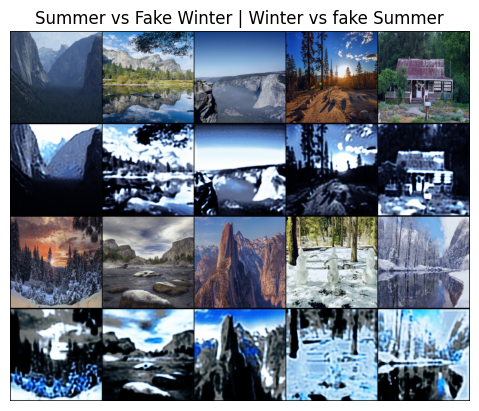

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 2
Load!


  0%|          | 1/246 [00:01<07:57,  1.95s/it, H_fake=0.171, H_real=0.869]

[D_loss] :  0.21196188032627106 ['D_W_loss'] :  0.15307316184043884 [D_S_loss] : 0.058888718485832214  [G_loss]:  17.081645965576172
[Adv Loss] :  1.3095792531967163  [Cycle Loss]:  1.0604650974273682 IdentityLoss: 1.0334835052490234


100%|██████████| 246/246 [05:49<00:00,  1.42s/it, H_fake=0.000932, H_real=0.00221]


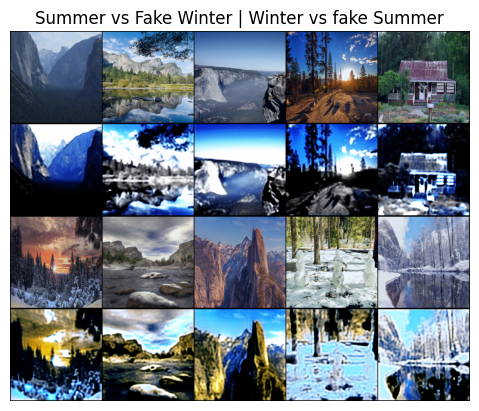

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 3
Load!


  0%|          | 1/246 [00:01<07:56,  1.94s/it, H_fake=0.345, H_real=0.69]

[D_loss] :  0.3651021718978882 ['D_W_loss'] :  0.09198132157325745 [D_S_loss] : 0.27312085032463074  [G_loss]:  15.492077827453613
[Adv Loss] :  1.3236234188079834  [Cycle Loss]:  0.9464930295944214 IdentityLoss: 0.9407047629356384


100%|██████████| 246/246 [05:49<00:00,  1.42s/it, H_fake=0.00048, H_real=0.0034]  


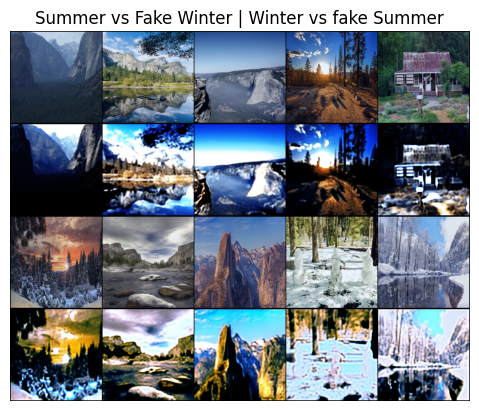

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 4
Load!


  0%|          | 1/246 [00:02<08:10,  2.00s/it, H_fake=0.356, H_real=0.872]

[D_loss] :  0.30202555656433105 ['D_W_loss'] :  0.10293185710906982 [D_S_loss] : 0.19909369945526123  [G_loss]:  14.100627899169922
[Adv Loss] :  1.6293036937713623  [Cycle Loss]:  0.8409476280212402 IdentityLoss: 0.8123695850372314


100%|██████████| 246/246 [05:47<00:00,  1.41s/it, H_fake=0.000373, H_real=0.00376]


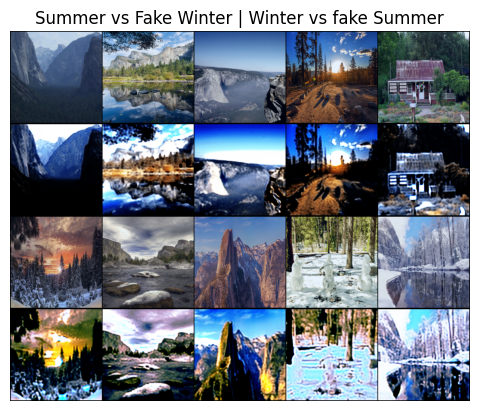

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 5
Load!


  0%|          | 1/246 [00:01<07:55,  1.94s/it, H_fake=0.108, H_real=0.875]

[D_loss] :  0.05677155405282974 ['D_W_loss'] :  0.014424115419387817 [D_S_loss] : 0.042347438633441925  [G_loss]:  15.510544776916504
[Adv Loss] :  1.7518882751464844  [Cycle Loss]:  0.9264286160469055 IdentityLoss: 0.898874044418335


100%|██████████| 246/246 [05:48<00:00,  1.41s/it, H_fake=0.00141, H_real=0.00362] 


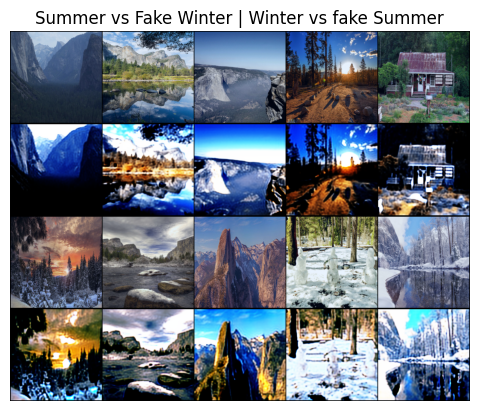

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 6
Load!


  0%|          | 1/246 [00:01<08:07,  1.99s/it, H_fake=0.216, H_real=0.811]

[D_loss] :  0.19241642951965332 ['D_W_loss'] :  0.04220984876155853 [D_S_loss] : 0.1502065807580948  [G_loss]:  13.360267639160156
[Adv Loss] :  1.7169201374053955  [Cycle Loss]:  0.787962794303894 IdentityLoss: 0.7527439594268799


100%|██████████| 246/246 [05:48<00:00,  1.42s/it, H_fake=0.000135, H_real=0.00383]


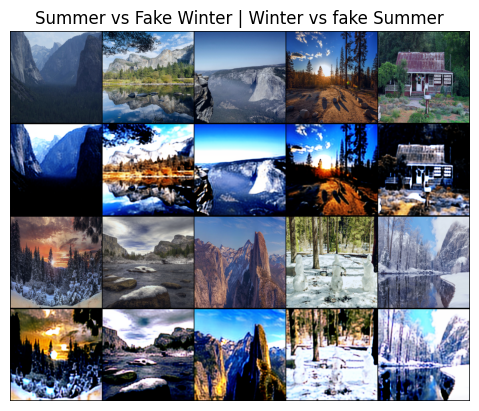

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 7
Load!


  0%|          | 1/246 [00:01<08:07,  1.99s/it, H_fake=0.0385, H_real=0.928]

[D_loss] :  0.047331515699625015 ['D_W_loss'] :  0.03597002103924751 [D_S_loss] : 0.011361494660377502  [G_loss]:  14.217568397521973
[Adv Loss] :  1.7937729358673096  [Cycle Loss]:  0.8335087299346924 IdentityLoss: 0.8177417516708374


100%|██████████| 246/246 [05:47<00:00,  1.41s/it, H_fake=0.000501, H_real=0.00392]


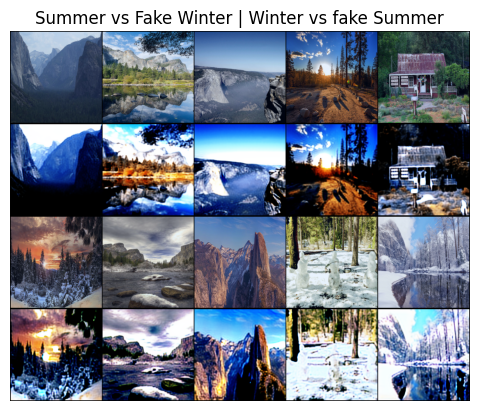

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 8
Load!


  0%|          | 1/246 [00:01<07:58,  1.95s/it, H_fake=0.0333, H_real=0.977]

[D_loss] :  0.026736408472061157 ['D_W_loss'] :  0.024342302232980728 [D_S_loss] : 0.0023941067047417164  [G_loss]:  13.314332008361816
[Adv Loss] :  1.8782126903533936  [Cycle Loss]:  0.7671422958374023 IdentityLoss: 0.7529392242431641


100%|██████████| 246/246 [05:46<00:00,  1.41s/it, H_fake=0.00015, H_real=0.00396] 


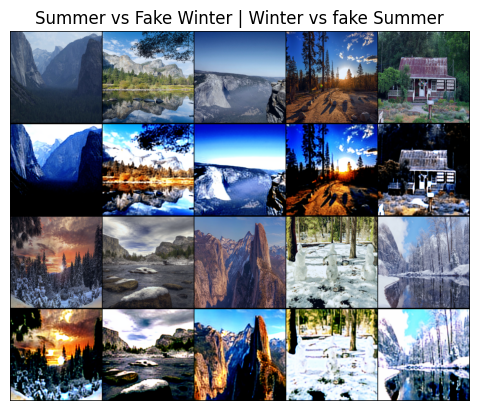

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 9
Load!


  0%|          | 1/246 [00:01<08:03,  1.97s/it, H_fake=0.0226, H_real=0.979]

[D_loss] :  0.003035451751202345 ['D_W_loss'] :  0.0016267659375444055 [D_S_loss] : 0.0014086859300732613  [G_loss]:  13.75147819519043
[Adv Loss] :  1.907116413116455  [Cycle Loss]:  0.7933825254440308 IdentityLoss: 0.7821070551872253


100%|██████████| 246/246 [05:47<00:00,  1.41s/it, H_fake=0.000218, H_real=0.00394]


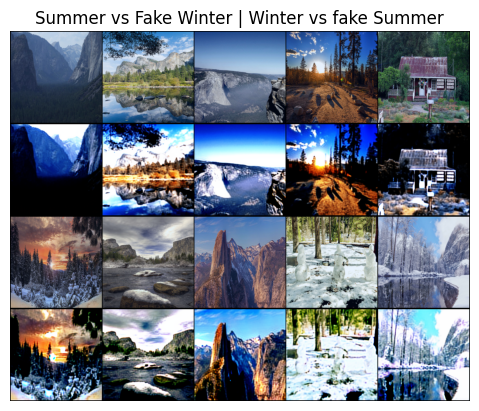

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 10
Load!


  0%|          | 1/246 [00:01<08:02,  1.97s/it, H_fake=0.0321, H_real=0.971]

[D_loss] :  0.0035855835303664207 ['D_W_loss'] :  0.0006287409923970699 [D_S_loss] : 0.002956842537969351  [G_loss]:  12.146249771118164
[Adv Loss] :  1.9089858531951904  [Cycle Loss]:  0.6893531084060669 IdentityLoss: 0.6687465906143188


100%|██████████| 246/246 [05:46<00:00,  1.41s/it, H_fake=0.000105, H_real=0.00399]


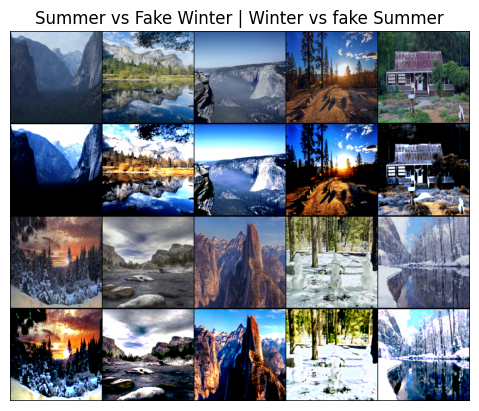

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 11
Load!


  0%|          | 1/246 [00:01<08:05,  1.98s/it, H_fake=0.0288, H_real=0.985]

[D_loss] :  0.005986219272017479 ['D_W_loss'] :  0.003714263439178467 [D_S_loss] : 0.002271955832839012  [G_loss]:  13.116670608520508
[Adv Loss] :  1.8834750652313232  [Cycle Loss]:  0.7545228004455566 IdentityLoss: 0.737593412399292


100%|██████████| 246/246 [05:46<00:00,  1.41s/it, H_fake=8.44e-5, H_real=0.00401] 


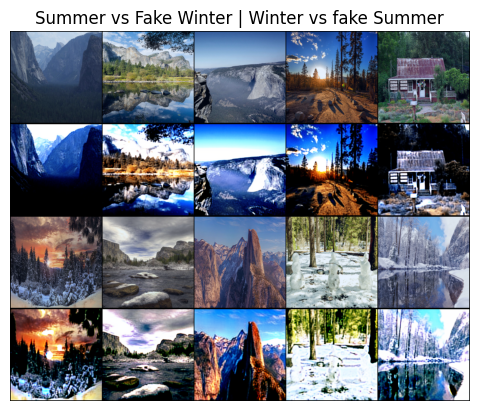

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 12
Load!


  0%|          | 1/246 [00:01<07:57,  1.95s/it, H_fake=0.0245, H_real=0.965]

[D_loss] :  0.00766996294260025 ['D_W_loss'] :  0.002576231025159359 [D_S_loss] : 0.005093731917440891  [G_loss]:  13.268342018127441
[Adv Loss] :  1.9018313884735107  [Cycle Loss]:  0.765620768070221 IdentityLoss: 0.742060661315918


100%|██████████| 246/246 [05:45<00:00,  1.40s/it, H_fake=0.000116, H_real=0.0031] 


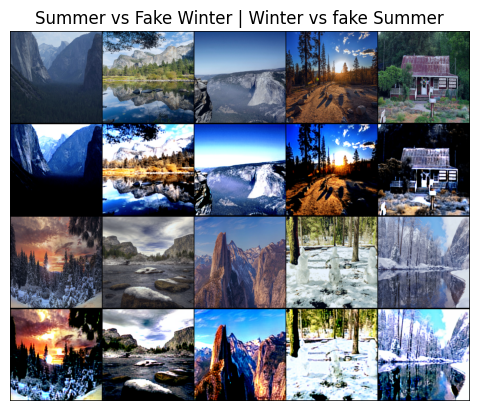

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 13
Load!


  0%|          | 1/246 [00:01<07:55,  1.94s/it, H_fake=0.124, H_real=0.973]

[D_loss] :  0.036968618631362915 ['D_W_loss'] :  0.008622115477919579 [D_S_loss] : 0.028346503153443336  [G_loss]:  12.827646255493164
[Adv Loss] :  1.8864867687225342  [Cycle Loss]:  0.7337191104888916 IdentityLoss: 0.7207937240600586


100%|██████████| 246/246 [05:45<00:00,  1.41s/it, H_fake=0.00221, H_real=0.00257] 


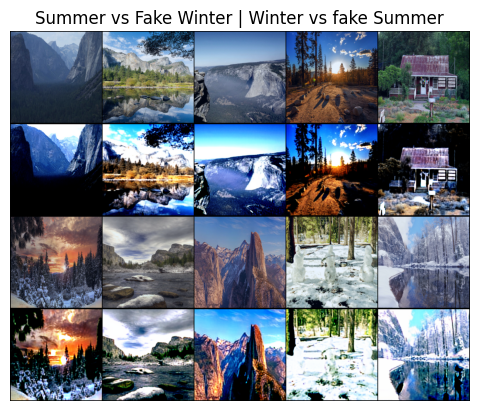

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 14
Load!


  0%|          | 1/246 [00:01<07:44,  1.89s/it, H_fake=0.544, H_real=0.828]

[D_loss] :  0.5266064405441284 ['D_W_loss'] :  0.0004222065326757729 [D_S_loss] : 0.5261842608451843  [G_loss]:  13.740591049194336
[Adv Loss] :  1.4443362951278687  [Cycle Loss]:  0.8296195268630981 IdentityLoss: 0.8000121116638184


100%|██████████| 246/246 [05:46<00:00,  1.41s/it, H_fake=9.58e-5, H_real=0.00403] 


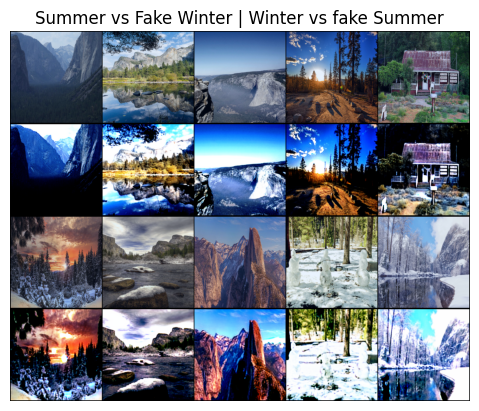

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch : 15
Load!


  0%|          | 1/246 [00:01<07:55,  1.94s/it, H_fake=0.0343, H_real=0.986]

[D_loss] :  0.004431648179888725 ['D_W_loss'] :  0.001143199042417109 [D_S_loss] : 0.0032884490210562944  [G_loss]:  14.636970520019531
[Adv Loss] :  1.899214506149292  [Cycle Loss]:  0.8553617000579834 IdentityLoss: 0.8368276357650757


100%|██████████| 246/246 [05:46<00:00,  1.41s/it, H_fake=3.79e-5, H_real=0.00402] 


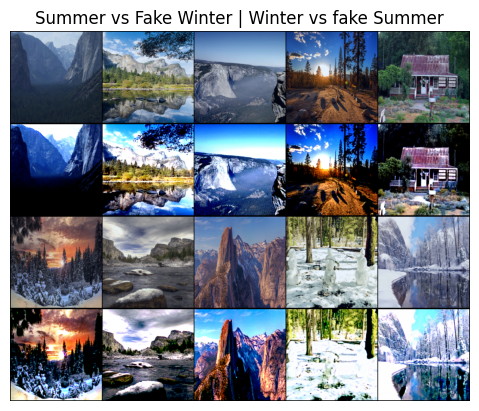

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


In [60]:
loss = {
        "D_loss": [],
        "G_loss":[],
        "Adv_loss":[],
        "Cycle_loss":[],
    "Identity_loss":[],
    }
for epoch in range(1,epochs+1):

    train_fn(disc_S,disc_W,gen_S,gen_W,opt_disc,opt_gen,l1,mse,d_scaler,g_scaler,train_loader,device,epoch,loss)
    #Show images
    show_images(val_loader)
#     show_images(val_loader)
    
    if SAVE_MODEL:
        save_checkpoint(gen_S, opt_gen, filename="/kaggle/working/SWgens.pth.tar")
        save_checkpoint(gen_W, opt_gen, filename="/kaggle/working/SWgenw.pth.tar")
        save_checkpoint(disc_S, opt_disc,
                        filename= "/kaggle/working/SWdiscs1.pth.tar")
        save_checkpoint(disc_W, opt_disc,
                        filename= "/kaggle/working/SWdiscw1.pth.tar")

#     print("Learning rate of Opt gen: ",opt_gen.param_groups[0]['lr'])
  
#     print("Learning rate of Opt Disc: ",opt_disc.param_groups[0]['lr'])
        
#     scheduler_disc.step()
#     scheduler_gen.step()

In [ ]:
opt_gen.param_groups[0]['lr']

In [ ]:
len(loss['D_loss'])

In [ ]:
loss

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=loss['G_loss'], x=[i for i in range(1,5+1)], mode='lines', name='Train Gen Loss (Loss_G)'))
fig.add_trace(go.Scatter(y=loss['D_loss'], x=[i for i in range(1,5+1)], mode='lines', name='Train Desc Loss (Loss_D)'))

In [ ]:
#SUBMISSION

In [ ]:
# Data Augmentation
transformations = transforms.Compose(
    [
        transforms.Resize([256,256],antialias=True),
#         transforms.RandomCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225]),
        
    ])



In [ ]:
dataset2 = SummerWinter(
    root_summer="/kaggle/input/gan-getting-started" + "/photo_jpg", 
    root_winter="/kaggle/input/gan-getting-started"+ "/monet_jpg", 
    transform=transformations
)

In [ ]:
val_loader2 = DataLoader(
    dataset2,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last= True,
)

In [ ]:
save_dir = '/kaggle/images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [ ]:
os.makedirs('../images', exist_ok=True)

In [ ]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
gen_W.eval()
for idx,(photo,monet) in enumerate(val_loader2):
    if(idx == 2000):
        photo = photo.type(Tensor)
        fake_monet = gen_W(photo).detach()
        fake_monet = make_grid(fake_monet, nrow=1, normalize=True)
        photo = make_grid(photo, nrow=1, normalize=True)
        images = torch.cat((photo,fake_monet),1)
        images = images.cpu().squeeze().permute(1,2,0)
        img_arr = images.numpy()
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        for i in range(3):  # Assuming the image has 3 color channels (RGB)
            img_arr[i] = img_arr[i] * std[i] + mean[i]
#         img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
#         img_arr = img_arr.astype(np.uint8)
        #     real = transforms.ToPILImage(img_arr)
        #     break
        #     im = Image.fromarray(fake_array)
        #     plt.imshow(photo)
        plt.imshow(img_arr)
        #     print()
        break
#     im.save(f"../images/fake_monet_{idx}.jpg")
    
    


In [ ]:
import shutil

shutil.make_archive('/kaggle/working/images', 'zip', root_dir='../images')

In [ ]:
img = Image.open("/kaggle/working/images/fake_monet_0.jpg")  
img.show()

In [ ]:
os.listdir()

In [ ]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

In [ ]:
import shutil

# Define the folder path you want to zip
folder_to_zip = '/kaggle/working/images'

# Specify the output zip file name
output_zip_filename = '/kaggle/working/images.zip'

# Create a zip archive of the folder
shutil.make_archive(output_zip_filename[:-4], 'zip', folder_to_zip)

# Check if the zip file has been created
print(f"Zip file '{output_zip_filename}' created successfully.")
